In [1]:
import sys
sys.path.append('../src')

import encoder_decoder_uttt as ed
from alpha_net_uttt import ConnectNet
from utictactoe_board import board as c_board
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# file = "../src/datasets/dataset_iter0_cpu1_0_2021-05-07"
file = "../src/datasets/iter_0/dataset_iter0_cpu0_1_2021-05-10"
with open(file, 'rb') as f:
    data = pickle.load(f)

In [3]:
i = 40
s,p,value = data[i]
cboard = ed.decode_board(s)
cboard.current_board

array([[' ', 'X', 'O', 'X', ' ', 'O', 'O', 'X', 'X'],
       ['X', ' ', 'X', ' ', ' ', 'O', 'O', ' ', 'X'],
       [' ', 'O', 'X', ' ', 'O', ' ', 'X', 'O', 'X'],
       [' ', 'X', 'O', 'O', ' ', 'X', 'X', ' ', 'O'],
       ['O', ' ', 'X', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', 'O', ' ', ' ', ' ', ' ', 'O', ' ', ' '],
       ['O', ' ', ' ', ' ', ' ', 'X', 'O', 'O', 'O'],
       ['X', ' ', ' ', 'X', 'O', ' ', ' ', 'X', ' '],
       [' ', ' ', ' ', ' ', 'X', 'X', ' ', ' ', 'O']], dtype='<U32')

In [4]:
cboard.old_move

(4, 2)

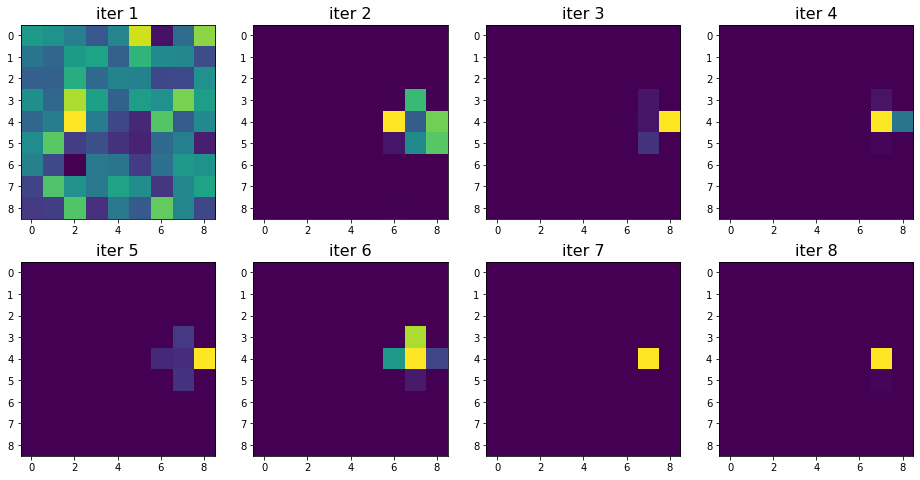

In [13]:
%matplotlib inline

fig = plt.figure(figsize=(16,8))

for j in range(8):
    net = ConnectNet()
    cuda = torch.cuda.is_available()
    if cuda:
        net.cuda()
    net.eval()
    net_filename = f"../src/model_data/uttt_current_net__iter{j}.pth.tar"
    checkpoint = torch.load(net_filename)
    net.load_state_dict(checkpoint['state_dict'])

    with torch.no_grad():
        encoded_s = ed.encode_board(cboard)
        encoded_s = encoded_s.transpose(2,0,1)
        encoded_s = torch.from_numpy(encoded_s).float().cuda()
        child_priors, value_estimate = net(encoded_s)
        child_priors = child_priors.detach().cpu().numpy().reshape(-1)
        value_estimate = value_estimate.item()

    p_mat = np.zeros((9,9))
    for i in range(child_priors.shape[0]):
        m = i // 9
        n = i % 9
        p_mat[m,n] = child_priors[i]

    ax_tmp = fig.add_subplot(2,4,j+1)
    plt.imshow(p_mat)
    ax_tmp.set_title(f'iter {j+1}', fontsize=16)
#     print(value_estimate)

plt.show()
fig.savefig(f"./pics/report-policy-iterations.png")

In [14]:
p_mat

array([[9.59691202e-13, 6.09587510e-17, 1.10652980e-11, 3.20916245e-11,
        3.97438917e-08, 3.99849314e-15, 1.78466287e-11, 1.93931720e-12,
        9.46735420e-13],
       [3.80365461e-11, 4.51576526e-10, 1.67323132e-12, 4.72657989e-11,
        3.14736627e-12, 1.51035244e-13, 1.31911151e-15, 4.95188557e-10,
        8.61042899e-13],
       [3.81311649e-09, 1.18686934e-13, 2.70124366e-17, 3.52517906e-12,
        6.01437854e-19, 1.07183813e-13, 3.13589568e-13, 1.61799744e-16,
        2.49244066e-13],
       [1.52520087e-07, 5.89486492e-16, 8.81435550e-12, 6.96386613e-15,
        1.51300587e-12, 7.16496647e-16, 7.46614681e-09, 3.55892023e-03,
        3.13745275e-12],
       [5.02944998e-15, 2.55875286e-11, 4.76223875e-07, 4.90955081e-08,
        1.32830951e-11, 4.91594248e-15, 4.12058638e-04, 9.82130408e-01,
        1.73017470e-04],
       [1.16151103e-10, 1.49325598e-15, 1.52629184e-13, 2.34958003e-15,
        8.99922525e-10, 6.86064432e-13, 1.41499923e-09, 1.37246232e-02,
        7.7